The below damage model is implemented for c = 1 with inital condition as gauss function

In [ ]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
"""
********************************************************************************
configures gpu
********************************************************************************
"""

import tensorflow as tf
from tensorflow.python.client import device_lib

# gpu_flg = 1   # 0, 1, or 2 (see: https://www.tensorflow.org/guide/gpu)
#               # 0: Restrict TensorFlow to only use the first GPU
#               # 1: Find the first GPU, and restrict the memory usage (adaptive)
#               # 2: Create 2 virtual GPUs with 1GB memory each

def config_gpu(gpu_flg):
    # gpu configuration
    tf.debugging.set_log_device_placement(False)   # True to check executing device carefully
    gpus = tf.config.experimental.list_physical_devices("GPU")

    if gpu_flg == 0:
        print("gpu_flg:", gpu_flg)
        if gpus:
            # Restrict TensorFlow to only use the first GPU
            try:
                tf.config.experimental.set_visible_devices(gpus[0], "GPU")
                logical_gpus = tf.config.experimental.list_logical_devices("GPU")
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
            except RuntimeError as e:
                # Visible devices must be set before GPUs have been initialized
                print(e)

    elif gpu_flg == 1:
        print("gpu_flg:", gpu_flg)
        if gpus:
            # Find the first GPU, and restrict the memory usage (adaptive)
            try:
                tf.config.experimental.set_visible_devices(gpus[0], "GPU")
                tf.config.experimental.set_memory_growth(gpus[0], True)
                logical_gpus = tf.config.experimental.list_logical_devices("GPU")
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
                print("\nDevice information;")
                print(device_lib.list_local_devices())
            except RuntimeError as e:
                # Memory growth must be set before GPUs have been initialized
                print(e)

    elif gpu_flg == 2:
        print("gpu_flg:", gpu_flg)
        if gpus:
            # Create 2 virtual GPUs with 1GB memory each
            try:
                tf.config.experimental.set_virtual_device_configuration(
                        gpus[0],
                        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10),
                         tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 2 ** 10)])
                logical_gpus = tf.config.experimental.list_logical_devices("GPU")
                print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
                print("\nDevice information;")
                print(device_lib.list_local_devices())
            except RuntimeError as e:
                # Virtual devices must be set before GPUs have been initialized
                print(e)

    else:
        raise NotImplementedError(">>>>> gpu_config")

In [ ]:
"""
********************************************************************************
all your network params
********************************************************************************
"""

# network structure
f_in = 3
f_out = 1
width = 2**6 # 2**6 = 64, 2**8 = 256
depth = 5

# training setting
n_epch = int(5e4) # 50000
n_btch = 0
c_tol = 1e-18

# Initializers
w_init = "Glorot"
b_init = "zeros"
act = "tanh"

# optimization
lr0 = 5e-3
gam = 1e-2
lrd_exp = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = lr0, decay_steps = n_epch, decay_rate = gam, staircase=False)
lrd_cos = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate = lr0, decay_steps = n_epch, alpha = gam)
lr = 5e-4
opt = "Adam"
f_scl = "minmax"  # scaling
laaf = False

# system params
c = 1. # velocity of wave

# weights for losses
w_ini = 1.
w_bnd = 1.
w_pde = 1

# boundary condition
BC = "Dir"  # "Dir" for Dirichlet, "Neu" for Neumann

# rarely changed parameters
f_mntr = 10
r_seed = 1234

def params():
    return      f_in, f_out, width, depth, \
                w_init, b_init, act, \
                lr, opt, \
                f_scl, laaf, c, \
                w_ini, w_bnd, w_pde, BC, \
                f_mntr, r_seed, \
                n_epch, n_btch, c_tol


In [ ]:
"""
**********************************************************************************
FDM for 2D damage model(wave equation) with no source, but with initial condition
**********************************************************************************
"""

import time
import numpy as np
import matplotlib.pylab as plt

def FDM_initial_condition(xmin, xmax, nx, dx,
                          ymin, ymax, ny, dy,
                          nt, dt,
                          x, y, t, u, c, BC):

    # Damage function
    A = 0.95
    x_d = 4
    y_d = 4
    xx_d = x
    yy_d = y
    sigma_d = 1.
    x_part_d = (xx_d - x_d)**2 / (2 * sigma_d**2)
    y_part_d = (yy_d - y_d)**2 / (2 * sigma_d**2)
    damage = A*np.exp(-(x_part_d + y_part_d))
    damage_assigner = np.zeros((1, nx, ny))
    damage_assigner[0,:,:] = damage[:,:]

    # Initialize u
    u[0, :, :] = np.exp(-((x - 5)/(0.3)) ** 2) * np.exp(-((y - 5)/(0.3)) ** 2)
    u[1, :, :] = u[0, :, :]
    t0 = time.time()
    for n in range(1, nt - 1):
        if n % int(1e2) == 0:
            print(">>>>> FDM computing... n: %d, nt: %d" % (n, nt))

        # forward difference of w in x-direction
        dxup = (u[n-1, 3:nx, 2:ny-1] - u[n-1, 2:nx-1, 2:ny-1])/dx;
        # forward difference of w in y-direction
        dyup = (u[n-1, 2:nx-1, 3:ny] - u[n-1, 2:nx-1, 2:ny-1])/dy;
        # backward difference of w in x-direction
        dxum = (u[n-1, 2:nx-1, 2:ny-1] - u[n-1, 1:nx-2, 2:ny-1])/dx;
        # backward difference of w in y-direction
        dyum = (u[n-1, 2:nx-1, 2:ny-1] - u[n-1, 2:nx-1, 1:ny-2])/dy;
        # first summand of the divergence (we average the damage, since we need it at non-integert points…)
        divx = ( (1 - 0.5*(damage_assigner[0, 3:nx, 2:ny-1] + damage_assigner[0, 2:nx-1, 2:ny-1]))*dxup - (1 - 0.5*(damage_assigner[0, 2:nx-1, 2:ny-1] + damage_assigner[0, 1:nx-2, 2:ny-1]))*dxum)/dx;
        # second summand of the divergence
        divy = ( (1 - 0.5*(damage_assigner[0, 2:nx-1, 3:ny] + damage_assigner[0, 2:nx-1, 2:ny-1]))*dyup - (1 - 0.5*(damage_assigner[0, 2:nx-1, 2:ny-1] + damage_assigner[0, 2:nx-1, 1:ny-2]))*dyum)/dy;
        u[n, 2:nx-1, 2:ny-1] = 2*u[n-1, 2:nx-1, 2:ny-1] - u[n-2, 2:nx-1, 2:ny-1] + (c**2) * (dt**2) * (divx + divy);

        if BC == "Dir":
            for i in range(1, nx - 1):
                u[n + 1, i,  0] = 0.
                u[n + 1, i, -1] = 0.
            for j in range(1, ny - 1):
                u[n + 1,  0, j] = 0.
                u[n + 1, -1, j] = 0.
            u[n,  0,  0] = 0.
            u[n, -1,  0] = 0.
            u[n,  0, -1] = 0.
            u[n, -1, -1] = 0.
        elif BC == "Neu":
            for i in range(1, nx - 1):
                u[n + 1, i,  0] = u[n + 1, i,  1]
                u[n + 1, i, -1] = u[n + 1, i, -2]
            for j in range(1, ny - 1):
                u[n + 1,  0, j] = u[n + 1,  1, j]
                u[n + 1, -1, j] = u[n + 1, -2, j]
            u[n,  0,  0] = (u[n,  1,  0] + u[n,  0,  1]) / 2
            u[n, -1,  0] = (u[n, -2,  0] + u[n, -1,  1]) / 2
            u[n,  0, -1] = (u[n,  1, -1] + u[n,  0, -2]) / 2
            u[n, -1, -1] = (u[n, -2, -1] + u[n, -1, -2]) / 2

    t1 = time.time()
    elps = t1 - t0
    print(">>>>> elapse time for FDM (sec):", elps)
    print(">>>>> elapse time for FDM (min):", elps / 60.)

    # plot FDM solutions
    fig  = plt.figure(figsize = (16, 4))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot_surface(x, y, u[20, :, :], cmap='coolwarm', edgecolor='none')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u (x, y)')
    ax.set_title('Snapshot 1')

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.plot_surface(x, y, u[80, :, :], cmap='coolwarm', edgecolor='none')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u (x, y)')
    ax.set_title('Snapshot 2')

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot_surface(x, y, u[180, :, :], cmap='coolwarm', edgecolor='none')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u (x, y)')
    ax.set_title('Snapshot 3')


    plt.tight_layout()
    plt.show()

    return u


In [ ]:
"""
********************************************************************************
prep dataset for pinn
********************************************************************************
"""

import numpy as np
import tensorflow as tf

def prp_dat(
        t, x, y,
        N_ini, N_bnd, N_pde):

    # dataset for PINN
    t_star, x_star, y_star = np.meshgrid(t, x, y)
    t_star, x_star, y_star = t_star.reshape(-1, 1), x_star.reshape(-1, 1), y_star.reshape(-1, 1)
    TX  = np.c_[t_star, x_star, y_star]
    lb = tf.cast(tf.constant(tf.reduce_min(TX, axis = 0)), dtype = tf.float32)
    ub = tf.cast(tf.constant(tf.reduce_max(TX, axis = 0)), dtype = tf.float32)

    # uniform sampling for initial condition
    t_ini = tf.ones((N_ini, 1), dtype = tf.float32) * lb[0]                   # [10000,1]
    x_ini = tf.random.uniform((N_ini, 1), lb[1], ub[1], dtype = tf.float32)   # [10000,1]
    y_ini = tf.random.uniform((N_ini, 1), lb[2], ub[2], dtype = tf.float32)   # [10000,1]
    u_ini = tf.exp(-((x - 5)/(0.3)) ** 2) * tf.exp(-((y - 5)/(0.3)) ** 2)     # [10000,1]

    # uniform sampling for boundary condition
    t_bndy = tf.random.uniform((int(N_bnd/2), 1), lb[0], ub[0], dtype = tf.float32)   # [5000,1]
    x_bndy = tf.random.uniform((int(N_bnd/2), 1), lb[1], ub[1], dtype = tf.float32)   # [5000,1]
    y_bndy = lb[2] + (ub[2] - lb[2]) * tf.keras.backend.random_bernoulli((int(N_bnd/2), 1), .5, dtype = tf.float32)  # [5000,1]
    t_bndx = tf.random.uniform((int(N_bnd/2), 1), lb[0], ub[0], dtype = tf.float32)   # [5000,1]
    x_bndx = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((int(N_bnd/2), 1), .5, dtype = tf.float32)  # [5000,1]
    y_bndx = tf.random.uniform((int(N_bnd/2), 1), lb[2], ub[2], dtype = tf.float32)   # [5000,1]

    # uniform sampling for PDE residual
    t_pde = tf.random.uniform((N_pde, 1), lb[0], ub[0], dtype = tf.float32)  # [50000,1]
    x_pde = tf.random.uniform((N_pde, 1), lb[1], ub[1], dtype = tf.float32)  # [50000,1]
    y_pde = tf.random.uniform((N_pde, 1), lb[2], ub[2], dtype = tf.float32)  # [50000,1]

    return TX, lb, ub, \
            t_ini, x_ini, y_ini, u_ini, \
            t_bndx, x_bndx, y_bndx, \
            t_bndy, x_bndy, y_bndy, \
            t_pde, x_pde, y_pde


In [ ]:
"""
********************************************************************************
Forward PINN implementation for damage model
********************************************************************************
"""

import os
import time
import datetime
import numpy as np
import tensorflow as tf

class PINN:
    def __init__(self,
                t_ini, x_ini, y_ini, u_ini,
                t_bndx, x_bndx, y_bndx,
                t_bndy, x_bndy, y_bndy,
                t_pde, x_pde, y_pde,
                f_in, f_out, width, depth,
                w_init = "Glorot", b_init = "zeros", act = "tanh",
                lr = 1e-3, opt = "Adam",
                f_scl = "minmax", laaf = False, c = 1.,
                w_ini = 1., w_bnd = 1., w_pde = 1., BC = "Dir",
                f_mntr = 10, r_seed = 1234):

        # configuration
        self.dat_typ = tf.float32
        self.f_in    = f_in
        self.f_out   = f_out
        self.width   = width
        self.depth   = depth
        self.w_init  = w_init
        self.b_init  = b_init
        self.act     = act
        self.lr      = lr
        self.opt     = opt
        self.f_scl   = f_scl
        self.laaf    = laaf
        self.c       = c
        self.w_ini   = w_ini
        self.w_bnd   = w_bnd
        self.w_pde   = w_pde
        self.BC      = BC
        self.f_mntr  = f_mntr
        self.r_seed  = r_seed
        self.random_seed(self.r_seed)

        # dataset
        self.t_ini = t_ini; self.x_ini = x_ini; self.y_ini = y_ini; self.u_ini = u_ini
        self.t_bndx = t_bndx; self.x_bndx = x_bndx; self.y_bndx = y_bndx
        self.t_bndy = t_bndy; self.x_bndy = x_bndy; self.y_bndy = y_bndy
        self.t_pde = t_pde; self.x_pde = x_pde; self.y_pde = y_pde

        # bounds (for feature scaling)
        bounds  = tf.concat([x_pde, y_pde, t_pde], 1)
        self.lb = tf.cast(tf.reduce_min (bounds, axis = 0), self.dat_typ)
        self.ub = tf.cast(tf.reduce_max (bounds, axis = 0), self.dat_typ)
        self.mn = tf.cast(tf.reduce_mean(bounds, axis = 0), self.dat_typ)

        # build
        self.structure = [self.f_in] + (self.depth-1) * [self.width] + [self.f_out]
        self.weights, self.biases, self.alphas, self.params = self.dnn_init(self.structure)

        # system param
        self.c = tf.constant(self.c, dtype = self.dat_typ)

        # optimization
        self.optimizer = self.opt_(self.lr, self.opt)
        self.ep_log       = []
        self.loss_log     = []
        self.loss_ini_log = []
        self.loss_bnd_log = []
        self.loss_pde_log = []

        print("\n************************************************************")
        print("****************     MAIN PROGRAM START     ****************")
        print("************************************************************")
        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         random seed  :", self.r_seed)
        print("         data type    :", self.dat_typ)
        print("         activation   :", self.act)
        print("         weight init  :", self.w_init)
        print("         bias   init  :", self.b_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         width        :", self.width)
        print("         depth        :", self.depth)
        print("         structure    :", self.structure)

    def random_seed(self, seed = 1234):
        os.environ["PYTHONHASHSEED"] = str(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)

    def dnn_init(self, strc):
        weights = []
        biases  = []
        alphas  = []
        params  = []
        for d in range(0, self.depth):   # depth = self.depth
            w = self.weight_init(shape = [strc[d], strc[d + 1]], depth = d)
            b = self.bias_init  (shape = [      1, strc[d + 1]], depth = d)
            weights.append(w)
            biases .append(b)
            params .append(w)
            params .append(b)
            if self.laaf == True and d < self.depth - 1:
                a = tf.Variable(1., dtype = self.dat_typ, name = "a" + str(d))
                params.append(a)
            else:
                a = tf.constant(1., dtype = self.dat_typ)
            alphas .append(a)
        return weights, biases, alphas, params

    def weight_init(self, shape, depth):
        in_dim  = shape[0]
        out_dim = shape[1]
        if self.w_init == "Glorot":
            std = np.sqrt(2 / (in_dim + out_dim))
        elif self.w_init == "He":
            std = np.sqrt(2 / in_dim)
        elif self.w_init == "LeCun":
            std = np.sqrt(1 / in_dim)
        else:
            raise NotImplementedError(">>>>> weight_init")
        weight = tf.Variable(
            tf.random.truncated_normal(shape = [in_dim, out_dim], \
            mean = 0., stddev = std, dtype = self.dat_typ), \
            dtype = self.dat_typ, name = "w" + str(depth)
            )
        return weight

    def bias_init(self, shape, depth):
        in_dim  = shape[0]
        out_dim = shape[1]
        if self.b_init == "zeros":
            bias = tf.Variable(
                tf.zeros(shape = [in_dim, out_dim], dtype = self.dat_typ), \
                dtype = self.dat_typ, name = "b" + str(depth)
                )
        elif self.b_init == "ones":
            bias = tf.Variable(
                tf.ones(shape = [in_dim, out_dim], dtype = self.dat_typ), \
                dtype = self.dat_typ, name = "b" + str(depth)
                )
        else:
            raise NotImplementedError(">>>>> bias_init")
        return bias

    def opt_(self, lr, opt):
        if opt == "SGD":
            optimizer = tf.keras.optimizers.SGD(
                learning_rate = lr, momentum = 0.0, nesterov = False
                )
        elif opt == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(
                learning_rate = lr, rho = 0.9, momentum = 0.0, centered = False
                )
        elif opt == "Adam":
            optimizer = tf.keras.optimizers.Adam(
                learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False
                )
        elif opt == "Adamax":
            optimizer = tf.keras.optimizers.Adamax(
                learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999
                )
        elif opt == "Nadam":
            optimizer = tf.keras.optimizers.Nadam(
                learning_rate = lr, beta_1 = 0.9, beta_2 = 0.999
                )
        else:
            raise NotImplementedError(">>>>> opt_")
        return optimizer

    def forward_pass(self, x):
        # feature scaling
        if self.f_scl == "minmax":
            z = 2. * (x - self.lb) / (self.ub - self.lb) - 1.
        elif self.f_scl == "mean":
            z = (x - self.mn) / (self.ub - self.lb)
        else:
            raise NotImplementedError(">>>>> forward_pass (f_scl)")
        # forward pass
        for d in range(0, self.depth - 1):
            w = self.weights[d]
            b = self.biases [d]
            a = self.alphas [d]
            u = tf.add(tf.matmul(z, w), b)
            u = tf.multiply(a, u)
            if self.act == "tanh":
                z = tf.tanh(u)
            elif self.act == "swish":
                z = tf.multiply(u, tf.sigmoid(u))
            elif self.act == "gelu":
                z = tf.multiply(u, tf.sigmoid(1.702 * u))
            elif self.act == "mish":
                z = tf.multiply(u, tf.tanh(tf.nn.softplus(u)))
            else:
                raise NotImplementedError(">>>>> forward_pass (act)")
        w = self.weights[-1]
        b = self.biases [-1]
        a = self.alphas [-1]
        u = tf.add(tf.matmul(z, w), b)
        u = tf.multiply(a, u)
        z = u   # identity mapping
        y = z
        return y

    def pde(self, t, x, y):
        t = tf.convert_to_tensor(t, dtype = self.dat_typ)
        x = tf.convert_to_tensor(x, dtype = self.dat_typ)
        y = tf.convert_to_tensor(y, dtype = self.dat_typ)

        # Known damage parameters
        A = tf.constant(value=0.95, dtype = self.dat_typ)
        x_0 = y_0  = tf.constant(value=4, dtype = self.dat_typ)
        sigma_x = sigma_y = tf.constant(value=1.0, dtype = self.dat_typ)

        with tf.GradientTape(persistent = True) as tp:
            tp.watch(t)
            tp.watch(x)
            tp.watch(y)
            u = self.forward_pass(tf.concat([t, x, y], 1))

            # Damage calculation
            x_part = ((x - x_0)**2)/(2*sigma_x**2)
            y_part = ((y - y_0)**2)/(2*sigma_y**2)
            damage = A*tf.exp(-(x_part + y_part)) # (6000,1)
            damage = tf.convert_to_tensor(damage, dtype = self.dat_typ)

            u_t = tp.gradient(u, t)
            u_x = tp.gradient(u, x)
            u_y = tp.gradient(u, y)
            d_x = tp.gradient(damage, x)
            d_y = tp.gradient(damage, y)

        u_tt = tp.gradient(u_t, t)
        u_xx = tp.gradient(u_x, x)
        u_yy = tp.gradient(u_y, y)
        del tp

        # # Source location
        # sigma_s = tf.constant(value=0.01, dtype='float32')
        # source_location = tf.exp(-(x - 2.5) **2 / (2 * sigma_s**2)) * tf.exp(-(y - 3) ** 2 / (2 * sigma_s**2))
        # source_value = 20 * tf.sin(30 * np.pi * (t) / 20) * source_location

        gv = u_tt - (self.c ** 2) * (((1-damage) * (u_xx + u_yy)) - (d_x*u_x + d_y*u_y))

        return u, gv

    def loss_ini(self, t, x, y, u):
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(t)
            tp.watch(x)
            tp.watch(y)
            u_, gv_ = self.pde(t, x, y)
        u_t_ = tp.gradient(u_, t)
        del tp
        loss = tf.reduce_mean(tf.square(u_)) \
                + tf.reduce_mean(tf.square(u_t_))
        return loss

    def loss_bnd(self, t, x, y):
        if self.BC == "Dir":
            u_, _ = self.pde(t, x, y)
            loss = tf.reduce_mean(tf.square(u_))
        elif self.BC == "Neu":
            with tf.GradientTape(persistent = True) as tp:
                tp.watch(t)
                tp.watch(x)
                tp.watch(y)
                u_, _ = self.pde(t, x, y)
            u_x_ = tp.gradient(u_, x)
            del tp
            loss = tf.reduce_mean(tf.square(u_x_))
        else:
            raise NotImplementedError(">>>>> loss_bnd")
        return loss

    def loss_bndx(self, t, x, y):
        if self.BC == "Dir":
            u_, _ = self.pde(t, x, y)
            loss = tf.reduce_mean(tf.square(u_))
        elif self.BC == "Neu":
            with tf.GradientTape(persistent = True) as tp:
                tp.watch(t)
                tp.watch(x)
                tp.watch(y)
                u_, _ = self.pde(t, x, y)
            u_x_ = tp.gradient(u_, x)
            del tp
            loss = tf.reduce_mean(tf.square(u_x_))
        else:
            raise NotImplementedError(">>>>> loss_bnd")
        return loss

    def loss_bndy(self, t, x, y):
        if self.BC == "Dir":
            u_, _ = self.pde(t, x, y)
            loss = tf.reduce_mean(tf.square(u_))
        elif self.BC == "Neu":
            with tf.GradientTape(persistent = True) as tp:
                tp.watch(t)
                tp.watch(x)
                tp.watch(y)
                u_, _ = self.pde(t, x, y)
            u_y_ = tp.gradient(u_, y)
            del tp
            loss = tf.reduce_mean(tf.square(u_y_))
        else:
            raise NotImplementedError(">>>>> loss_bnd")
        return loss

    def loss_pde(self, t, x, y):
        _, gv_ = self.pde(t, x, y)
        loss = tf.reduce_mean(tf.square(gv_))
        return loss

    @tf.function
    def loss_glb(self,
                t_ini, x_ini, y_ini, u_ini,
                t_bndx, x_bndx, y_bndx,
                t_bndy, x_bndy, y_bndy,
                t_pde, x_pde, y_pde):
        loss_ini = self.loss_ini(t_ini, x_ini, y_ini, u_ini)
        loss_bnd = self.loss_bndx(t_bndx, x_bndx, y_bndx) \
                    + self.loss_bndy(t_bndy, x_bndy, y_bndy)
        loss_pde = self.loss_pde(t_pde, x_pde, y_pde)
        loss = self.w_ini * loss_ini + self.w_bnd * loss_bnd + self.w_pde * loss_pde
        return loss

    def loss_grad(self,
                t_ini, x_ini, y_ini, u_ini,
                t_bndx, x_bndx, y_bndx,
                t_bndy, x_bndy, y_bndy,
                t_pde, x_pde, y_pde):
        with tf.GradientTape(persistent=True) as tp:
            loss = self.loss_glb(t_ini, x_ini, y_ini, u_ini,
                                t_bndx, x_bndx, y_bndx,
                                t_bndy, x_bndy, y_bndy,
                                t_pde, x_pde, y_pde)
        grad = tp.gradient(loss, self.params)
        del tp
        return loss, grad

    @tf.function
    def grad_desc(self,
                t_ini, x_ini, y_ini, u_ini,
                t_bndx, x_bndx, y_bndx,
                t_bndy, x_bndy, y_bndy,
                t_pde, x_pde, y_pde):
        loss, grad = self.loss_grad(t_ini, x_ini, y_ini, u_ini,
                                    t_bndx, x_bndx, y_bndx,
                                    t_bndy, x_bndy, y_bndy,
                                    t_pde, x_pde, y_pde)
        self.optimizer.apply_gradients(zip(grad, self.params))
        return loss

    def train(self,
            epoch = 10 ** 5, batch = 2 ** 6, tol = 1e-5):
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         batch size     :", batch)
        print("         convergence tol:", tol)

        t_ini = self.t_ini; x_ini = self.x_ini; y_ini = self.y_ini; u_ini = self.u_ini
        t_bndx = self.t_bndx; x_bndx = self.x_bndx; y_bndx = self.y_bndx
        t_bndy = self.t_bndy; x_bndy = self.x_bndy; y_bndy = self.y_bndy
        t_pde = self.t_pde; x_pde = self.x_pde; y_pde = self.y_pde

        t0 = time.time()
        for ep in range(epoch):
            es_pat      = 0
            es_crt      = 5
            min_loss    = 100.
            ep_loss     = 0.
            ep_loss_ini = 0.
            ep_loss_bnd = 0.
            ep_loss_pde = 0.

            # full-batch training
            if batch == 0:
                ep_loss = self.grad_desc(t_ini, x_ini, y_ini, u_ini,
                                         t_bndx, x_bndx, y_bndx,
                                         t_bndy, x_bndy, y_bndy,
                                         t_pde, x_pde, y_pde)
                ep_loss_ini = self.loss_ini(t_ini, x_ini, y_ini, u_ini)
                ep_loss_bnd = self.loss_bndx(t_bndx, x_bndx, y_bndx) \
                                + self.loss_bndy(t_bndy, x_bndy, y_bndy)
                ep_loss_pde = self.loss_pde(t_pde, x_pde, y_pde)

            # mini-batch training
            else:
                bound_b = min(self.x_ini.shape[0],
                                self.x_bndx.shape[0],
                                self.x_bndy.shape[0],
                                self.x_pde.shape[0])
                idx_b = np.random.permutation(bound_b)

                for idx in range(0, bound_b, batch):
                    # batch for initial condition
                    t_ini_b = tf.convert_to_tensor(t_ini.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    x_ini_b = tf.convert_to_tensor(x_ini.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    y_ini_b = tf.convert_to_tensor(y_ini.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    u_ini_b = tf.convert_to_tensor(u_ini.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    # batch for boudary condition
                    t_bndx_b = tf.convert_to_tensor(t_bndx.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    x_bndx_b = tf.convert_to_tensor(x_bndx.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    y_bndx_b = tf.convert_to_tensor(y_bndx.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    t_bndy_b = tf.convert_to_tensor(t_bndy.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    x_bndy_b = tf.convert_to_tensor(x_bndy.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    y_bndy_b = tf.convert_to_tensor(y_bndy.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    # batch for PDE residual
                    t_pde_b = tf.convert_to_tensor(t_pde.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    x_pde_b = tf.convert_to_tensor(x_pde.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    y_pde_b = tf.convert_to_tensor(y_pde.numpy()[idx_b[idx:idx+batch if idx+batch < bound_b else bound_b]], dtype = self.dat_typ)
                    # compute loss and perform gradient descent
                    loss_b = self.grad_desc(t_ini_b, x_ini_b, y_ini_b, u_ini_b,
                                            t_bndx_b, x_bndx_b, y_bndx_b,
                                            t_bndy_b, x_bndy_b, y_bndy_b,
                                            t_pde_b, x_pde_b, y_pde_b)
                    loss_ini_b = self.loss_ini(t_ini_b, x_ini_b, y_ini_b, u_ini_b)
                    loss_bnd_b = self.loss_bndx(t_bndx_b, x_bndx_b, y_bndx_b) \
                                + self.loss_bndy(t_bndy_b, x_bndy_b, y_bndy_b)
                    loss_pde_b = self.loss_pde(t_pde_b, x_pde_b, y_pde_b)
                    # per batch -> per epoch
                    ep_loss     += loss_b     / int(bound_b / batch)
                    ep_loss_ini += loss_ini_b / int(bound_b / batch)
                    ep_loss_bnd += loss_bnd_b / int(bound_b / batch)
                    ep_loss_pde += loss_pde_b / int(bound_b / batch)

            if ep % self.f_mntr == 0:
                elps = time.time() - t0
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                self.loss_ini_log.append(ep_loss_ini)
                self.loss_bnd_log.append(ep_loss_bnd)
                self.loss_pde_log.append(ep_loss_pde)
                print("ep: %d, loss: %.3e, loss_ini: %.3e, loss_bnd: %.3e, loss_pde: %.3e, elps: %.3f"
                    % (ep, ep_loss, ep_loss_ini, ep_loss_bnd, ep_loss_pde, elps))
                t0 = time.time()

                if ep_loss < min_loss:
                    es_pat = 0
                    min_loss = ep_loss
                else:
                    es_pat += 1
                    print(">>>>> observed loss increase, patience: %d" % es_pat)

            if ep_loss < tol:
                print(">>>>> program terminating with the loss converging to its tolerance.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                break
            elif es_crt < es_pat:
                print(">>>>> program terminating with early stopping triggered.")
                print("\n************************************************************")
                print("*****************     MAIN PROGRAM END     *****************")
                print("************************************************************")
                print(">>>>> end time:", datetime.datetime.now())
                break
            else:
                pass

        print("\n************************************************************")
        print("*****************     MAIN PROGRAM END     *****************")
        print("************************************************************")
        print(">>>>> end time:", datetime.datetime.now())

    def infer(self, t, x, y):
        u_, gv_ = self.pde(t, x, y)
        return u_, gv_


gpu_flg: 0
1 Physical GPUs, 1 Logical GPU
tmin: 0.000, tmax: 6.000, nt: 200, dt: 3.000e-02
xmin: 0.000, xmax: 10.000, nx: 166, dx: 6.000e-02
ymin: 0.000, ymax: 10.000, ny: 166, dy: 6.000e-02
>>>>> FDM computing... n: 100, nt: 200
>>>>> elapse time for FDM (sec): 0.19011354446411133
>>>>> elapse time for FDM (min): 0.0031685590744018554


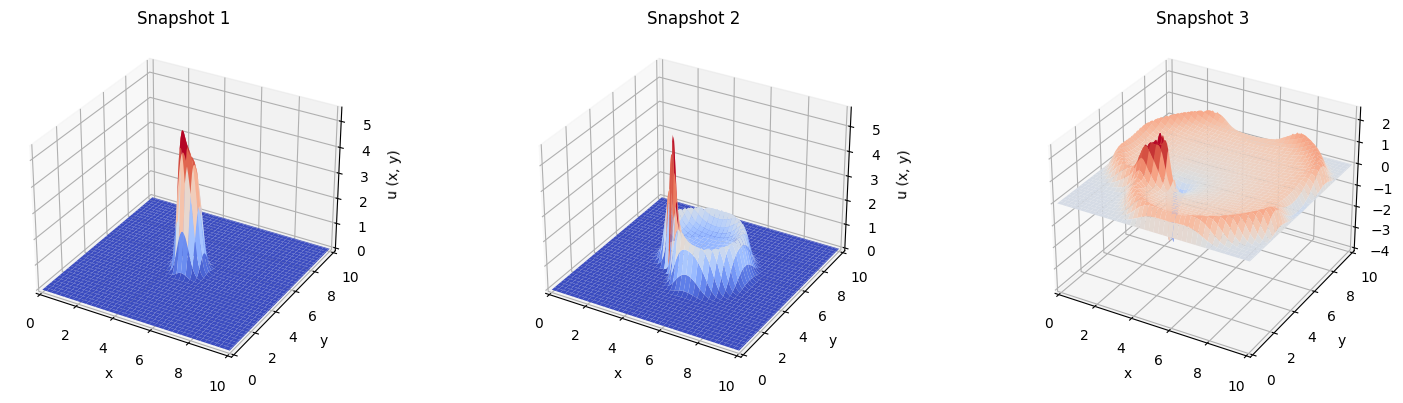


************************************************************
****************     MAIN PROGRAM START     ****************
************************************************************
>>>>> start time: 2023-08-22 22:42:40.111785
>>>>> configuration;
         random seed  : 1234
         data type    : <dtype: 'float32'>
         activation   : tanh
         weight init  : Glorot
         bias   init  : zeros
         learning rate: 0.0005
         optimizer    : Adam
         width        : 64
         depth        : 5
         structure    : [3, 64, 64, 64, 64, 1]


In [ ]:
"""
********************************************************************************
main file to execute
********************************************************************************
"""

# gpu confiuration
config_gpu(gpu_flg = 0)

# params
f_in, f_out, width, depth, \
w_init, b_init, act, \
lr, opt, \
f_scl, laaf, c, \
w_ini, w_bnd, w_pde, BC, \
f_mntr, r_seed, \
n_epch, n_btch, c_tol = params()

# domain
tmin = 0.; tmax =  6.;
xmin = 0.; xmax =  10.;
ymin = 0.; ymax =  10.;
dx = 0.06;
dy = dx;
nx = int(xmax/dx)
ny = int(ymax/dy)

x_ = np.linspace(xmin, xmax, nx)
y_ = np.linspace(ymin, ymax, ny)

# Create meshgrid
x, y = np.meshgrid(x_, y_)

# Parameters
CFL = 0.5
c = 1
dt = CFL * dx / c
nt = int(tmax / dt)
t_ = np.linspace(tmin, tmax, nt)

u    = np.empty((nt, nx, ny))
print("tmin: %.3f, tmax: %.3f, nt: %d, dt: %.3e" % (tmin, tmax, nt, dt))
print("xmin: %.3f, xmax: %.3f, nx: %d, dx: %.3e" % (xmin, xmax, nx, dx))
print("ymin: %.3f, ymax: %.3f, ny: %d, dy: %.3e" % (ymin, ymax, ny, dy))

# FD
u_FDM = FDM_initial_condition(xmin, xmax, nx, dx,
                              ymin, ymax, ny, dy,
                              nt, dt,
                              x, y, t_, u, c, BC)

# prep data
TX, lb, ub, \
t_ini, x_ini, y_ini, u_ini, \
t_bndx, x_bndx, y_bndx, \
t_bndy, x_bndy, y_bndy, \
t_pde, x_pde, y_pde = prp_dat(t_, x_, y_,
                                N_ini = int(1e4),  # 10000
                                N_bnd = int(1e4),  # 10000
                                N_pde = int(5e4))  # 50000

pinn = PINN(t_ini, x_ini, y_ini, u_ini,
            t_bndx, x_bndx, y_bndx,
            t_bndy, x_bndy, y_bndy,
            t_pde, x_pde, y_pde,
            f_in, f_out, width, depth,
            w_init, b_init, act,
            lr, opt,
            f_scl, laaf, c,
            w_ini, w_bnd, w_pde, BC,
            f_mntr, r_seed)

In [ ]:
t0 = time.time()
with tf.device("/device:GPU:0"):
  pinn.train(epoch = n_epch, batch = n_btch, tol = c_tol)
t1 = time.time()
elps = t1 - t0
print(">>>>> elapse time for training (sec):", elps)
print(">>>>> elapse time for training (min):", elps / 60.)

>>>>> training setting;
         # of epoch     : 50000
         batch size     : 0
         convergence tol: 1e-18


Streaming output truncated to the last 5000 lines.
ep: 60, loss: 1.677e-05, loss_ini: 9.067e-06, loss_bnd: 8.956e-06, loss_pde: 3.852e-07, elps: 3.635
ep: 70, loss: 1.903e-05, loss_ini: 5.556e-06, loss_bnd: 1.139e-05, loss_pde: 3.105e-07, elps: 3.610
ep: 80, loss: 1.287e-05, loss_ini: 5.447e-06, loss_bnd: 7.502e-06, loss_pde: 2.664e-07, elps: 3.673
ep: 90, loss: 1.210e-05, loss_ini: 5.592e-06, loss_bnd: 5.838e-06, loss_pde: 2.385e-07, elps: 3.639
ep: 100, loss: 1.078e-05, loss_ini: 4.991e-06, loss_bnd: 5.528e-06, loss_pde: 2.223e-07, elps: 3.594
ep: 110, loss: 9.770e-06, loss_ini: 4.455e-06, loss_bnd: 5.039e-06, loss_pde: 2.114e-07, elps: 3.591
ep: 120, loss: 9.018e-06, loss_ini: 4.079e-06, loss_bnd: 4.650e-06, loss_pde: 2.020e-07, elps: 3.642
ep: 130, loss: 8.323e-06, loss_ini: 3.794e-06, loss_bnd: 4.266e-06, loss_pde: 1.938e-07, elps: 3.596
ep: 140, loss: 7.693e-06, loss_ini: 3.551e-06, loss_bnd: 3.898e-06, loss_pde: 1.862e-07, elps: 3.598
ep: 150, loss: 7.127e-06, loss_ini: 3.339e-0

In [ ]:
# inference
x_inf, y_inf = np.meshgrid(x_, y_)
x_inf, y_inf = x_inf.reshape(-1, 1), y_inf.reshape(-1, 1)
elps = 0
for t in t_:
  t_inf = np.ones_like(x_inf) * t
  t0 = time.time()
  u_, gv_ = pinn.infer(t_inf, x_inf, y_inf)
  t1 = time.time()
  temp = t1 - t0
  elps += temp
print(">>>>> elapse time for inference (sec):", elps)
print(">>>>> elapse time for inference (min):", elps / 60.)

>>>>> elapse time for inference (sec): 17.477701902389526
>>>>> elapse time for inference (min): 0.2912950317064921


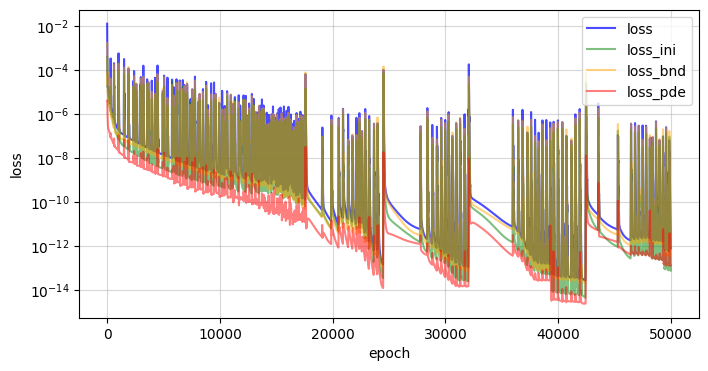

In [ ]:
plt.figure(figsize = (8, 4))
plt.plot(pinn.ep_log, pinn.loss_log,     alpha = .7, color = 'blue', linestyle = "-",  label = "loss")
plt.plot(pinn.ep_log, pinn.loss_ini_log, alpha = .5, color = 'green', linestyle = "-", label = "loss_ini")
plt.plot(pinn.ep_log, pinn.loss_bnd_log, alpha = .5,  color = 'orange', linestyle = "-", label = "loss_bnd")
plt.plot(pinn.ep_log, pinn.loss_pde_log, alpha = .5, color = 'red', linestyle = "-", label = "loss_pde")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc = "upper right")
plt.grid(alpha = .5)
plt.show()

In [ ]:
for tm in range(nt):
  if tm % 10 == 0:
      tm = np.array([tm])

      t_inf = np.unique(TX[:,0:1])
      x_inf = np.unique(TX[:,1:2])
      y_inf = np.unique(TX[:,2:3])

      x_inf, y_inf = np.meshgrid(x_inf, y_inf)
      x_inf, y_inf = x_inf.reshape(-1, 1), y_inf.reshape(-1, 1)
      t_inf = np.tile(t_inf.reshape(-1, 1), (1, x_inf.shape[0])).T[:,tm]

      u_hat, gv_hat = pinn.infer(t_inf, x_inf, y_inf)

      fig  = plt.figure(figsize = (6, 6))
      ax   = fig.add_subplot(1, 1, 1, projection = "3d")
      surf = ax.plot_surface(x, y, tf.reshape(u_hat, shape = [nx, ny]), cmap = "coolwarm",edgecolor='none')
                          #linewidth = 0, vmin = -.5, vmax = .5)

      ax.set_xlim(xmin, xmax)
      ax.set_ylim(ymin, ymax)
      #ax.set_zlim(-1, 1)
      ax.set_xlabel("x", fontstyle = "italic")
      ax.set_ylabel("y", fontstyle = "italic")
      ax.set_zlabel("u (t, x, y)", fontstyle = "italic")
      plt.show()



NameError: ignored

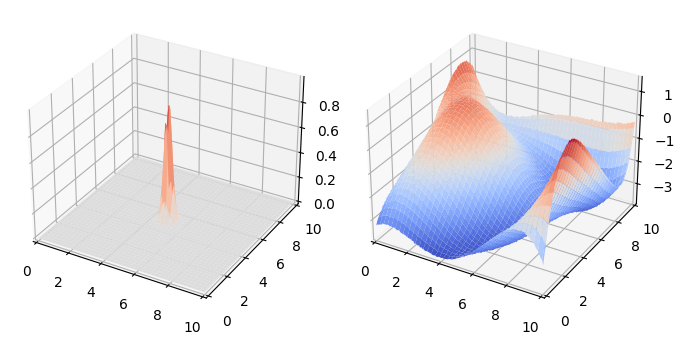

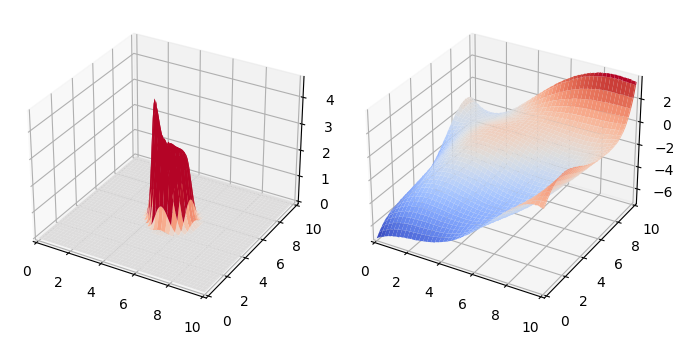

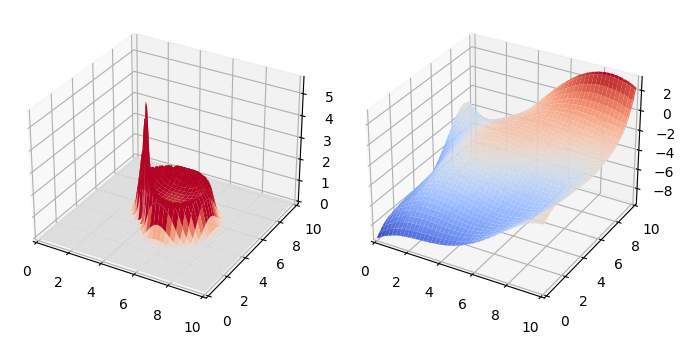

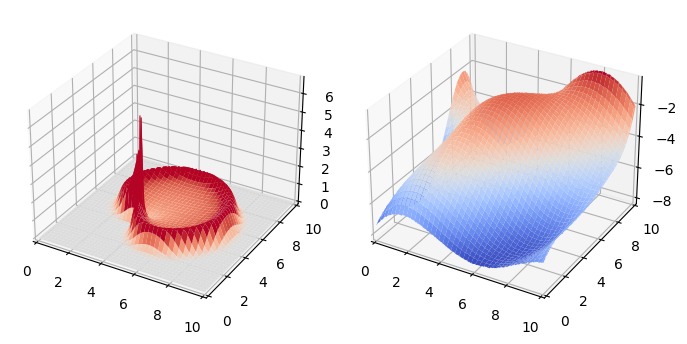

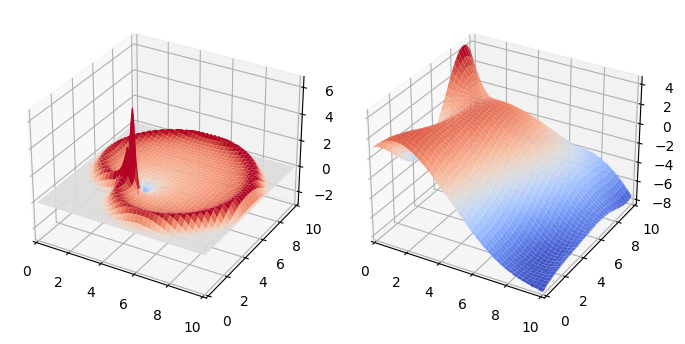

In [ ]:
for n in range(nt):
    if n % (int(nt / 5)) == 0:
        t = n * dt   # convert to real time
        u_fdm = u_FDM[n,:,:]
        n = np.array([n])
        t_inf = np.unique(TX[:,0:1])
        x_inf = np.unique(TX[:,1:2])
        y_inf = np.unique(TX[:,2:3])
        x_inf, y_inf = np.meshgrid(x_inf, y_inf)
        x_inf, y_inf = x_inf.reshape(-1, 1), y_inf.reshape(-1, 1)
        t_inf = np.tile(t_inf.reshape(-1, 1), (1, x_inf.shape[0])).T[:,n]
        u_, gv_ = pinn.infer(t_inf, x_inf, y_inf)

        fig = plt.figure(figsize=(16, 4))

        ax = fig.add_subplot(1, 1, 1, projection = "3d")
        ax.plot_surface(x, y, u_fdm, cmap="coolwarm", vmin = -1., vmax = 1.)
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

        ax = fig.add_subplot(1, 2, 2, projection = "3d")
        ax.plot_surface(x, y, u_.numpy().reshape(nx, ny), cmap="coolwarm", edgecolor='none')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)


        plt.show()


In [ ]:
u_fdm = u_FDM[tm,:,:]
u_diff = u_fdm - u_.numpy().reshape(nx, ny)
u_l2  = np.linalg.norm(u_diff, ord=2) / np.linalg.norm(u_fdm, ord=2)
u_mse = np.mean(np.square(u_diff)) / np.sqrt(nx * ny)
u_sem = np.std (np.square(u_diff), ddof = 1) / np.sqrt(nx * ny)
print("t: %.3f, l2: %.3e, mse: %.3e, sem: %.3e" % (t, u_l2, u_mse, u_sem))

t: 4.800, l2: inf, mse: 5.404e-10, sem: 5.597e-10


<ipython-input-24-9c316a625026>:3: RuntimeWarning: divide by zero encountered in double_scalars
  u_l2  = np.linalg.norm(u_diff, ord=2) / np.linalg.norm(u_fdm, ord=2)


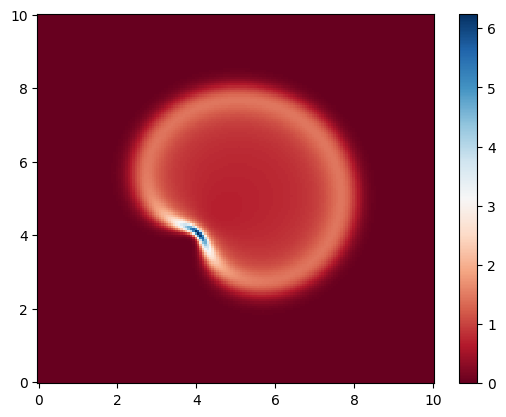

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl
import matplotlib.pyplot as mpl
from pylab import *

fig, ax = plt.subplots()
Z = u_FDM[100,:,:]
p = ax.pcolor(x, y, Z, cmap=matplotlib.cm.RdBu, vmin=abs(Z).min(), vmax=abs(Z).max())
cb = fig.colorbar(p, ax=ax)